In [160]:
import sys, os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


params = {"ytick.color" : "w",
          "xtick.color" : "w",
          "axes.labelcolor" : "w",
          "axes.edgecolor" : "w"}
plt.rcParams.update(params)


sys.path.append('../')
import xai
from xai.xdata import XData
from importlib import reload
reload(xai)
reload(xai.xdata)
import xai
from xai.xdata import XData

In [158]:
csv_path = 'data/adult.data'
csv_columns = ["age", "workclass", "fnlwgt", "education", "education-num", "marital-status",
                   "occupation", "relationship", "ethnicity", "gender", "capital-gain", "capital-loss",
                   "hours-per-week", "native-country", "loan"]

In [159]:
df = pd.read_csv(csv_path, names=csv_columns)
df.head()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,ethnicity,gender,capital-gain,capital-loss,hours-per-week,native-country,loan
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


In [55]:
xd = XData("loan", df)
xd.set_protected(["gender", "ethnicity", "native-country", "age"])

In [56]:
xd.df.head()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,ethnicity,gender,capital-gain,capital-loss,hours-per-week,native-country,loan
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


['gender', 'ethnicity', 'native-country', 'age']


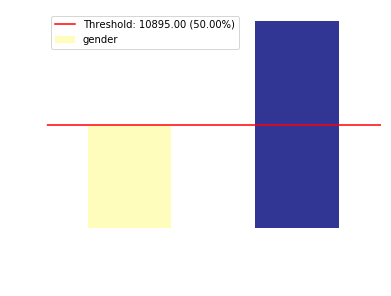

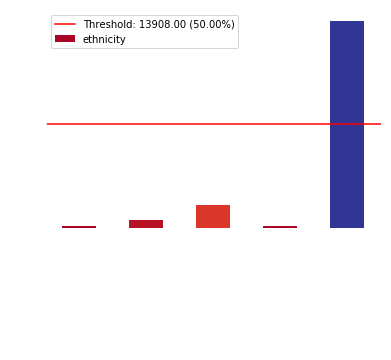

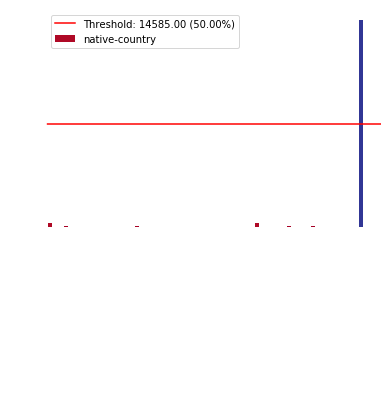

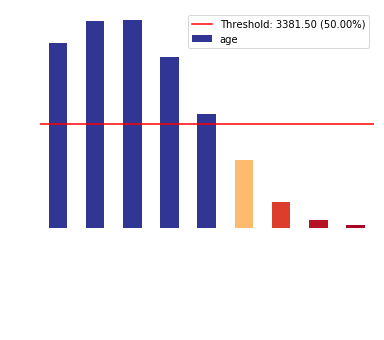

In [57]:
ims = xd.show_imbalances(cross=[])

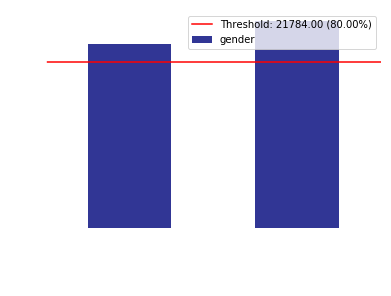

In [67]:
xd.set_threshold(0.8)
im = xd.show_imbalance("gender", cross=[])

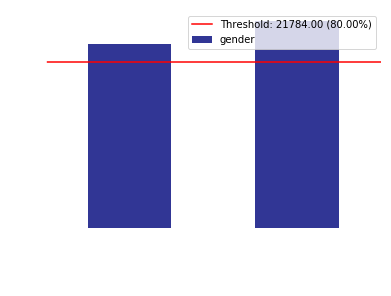

In [68]:
xd.balance("gender", cross=[])
im = xd.show_imbalance("gender", cross=[])

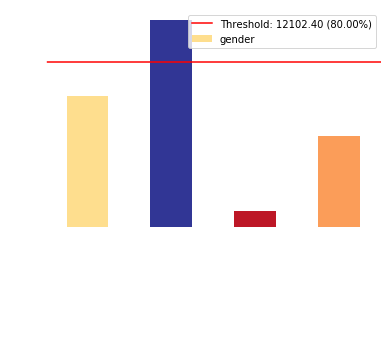

In [73]:
im = xd.show_imbalance("gender")

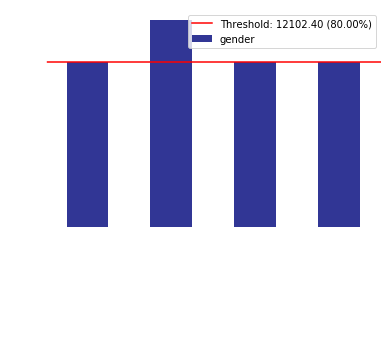

In [74]:
im = xd.balance("gender")
im = xd.show_imbalance("gender")

In [75]:
xd.reset()

# Validation dataset

### How much data?
How do we know how much data? Well, it's hard, but normally it depends on:

* The complexity of the problem, nominally the unknown underlying function that best relates your input variables to the output variable.
* The complexity of the learning algorithm, nominally the algorithm used to inductively learn the unknown underlying mapping function from specific examples.

### Statistical heuristics

* Factor of the number of classes: There must be x independent examples for each class, where x could be tens, hundreds, or thousands (e.g. 5, 50, 500, 5000).
* Factor of the number of input features: There must be x% more examples than there are input features, where x could be tens (e.g. 10).
* Factor of the number of model parameters: There must be x independent examples for each parameter in the model, where x could be tens (e.g. 10).

### Papers
* Small sample size effects in statistical pattern recognition: Recommendations for practitioners: https://sci2s.ugr.es/keel/pdf/specific/articulo/raudys91.pdf
* 39 Dimensionality and sample size considerations in pattern recognition practice: https://www.sciencedirect.com/science/article/pii/S0169716182020422

In [137]:
# Before we balance again on sub classes, let's create a validation set
xd.reset()


import random, math

def group_by_columns(df, all_cols, bins=0):
    group_list = []
    for c in all_cols:
        col = df[c]
        if c in xd._categorical_cols or not bins:
            grp = c
        else:
            col_min = col.min()
            col_max = col.max()
            # TODO: Use the original bins for display purposes as they may come normalised
            col_bins = pd.cut(col, list(np.linspace(col_min, col_max, bins)))
            grp = col_bins

        group_list.append(grp)

    grouped = df.groupby(group_list)
    return grouped 


def split_test_set(
        df,
        target_name,
        key_features=[],
        examples_per_class=20,
        sample_type="half",
        bins=5, 
        random_state=None):
    """
    sample_type: Can be "half", or "upsample"
    """
    
    if random_state:
        random.setstate(random_state)
    
    tmp_df = df.copy()
    
    grouped = group_by_columns(tmp_df, key_features, bins=9)
    
    selected_idxs = []
    
    def sample(x):
        group_size = x.shape[0]
        curr_group = None
        if sample_type == "upsample":
            return x.sample(examples_per_class, replace=True)
        elif sample_type == "half":
            if group_size > 2*examples_per_class:
                curr_group = x.sample(examples_per_class)
            else:
                if group_size > 1:
                    curr_group = x.sample(math.floor(group_size / 1))
                else:
                    if random.random() > 0.5:
                        curr_group = x
                    else:
                        curr_group = x.sample(0)
        else:
            raise(f"Sampling type provided not found: given {sample_type}, "\
                 "expected: 'half' or 'upsample'")
                    
        selected_idxs.append(curr_group.index.values)
        return curr_group
    
    tmp_df = grouped.apply(sample)
    
    selected_idx = np.concatenate(selected_idxs)
    
    train_idx = np.full(df.shape[0], True, dtype=bool)
    train_idx[selected_idx] = False
    test_idx = np.full(df.shape[0], False, dtype=bool)
    test_idx[selected_idx] = True
    
    df_train = df.iloc[train_idx] 
    df_test = df.iloc[test_idx]
    
    return df_train, df_test
    
df_train, df_test = split_test_set(
    xd.df,
    "loan",
    examples_per_class=20,
    key_features=["gender", "ethnicity", "age"],
    bins=9)

print(df_train.shape)
print(df_test.shape)

(31265, 15)
(1296, 15)


,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,ethnicity,gender,capital-gain,capital-loss,hours-per-week,native-country,loan


In [ ]:
xd.reset()
xd.balance("gender")
im = xd.show_imbalance("gender")

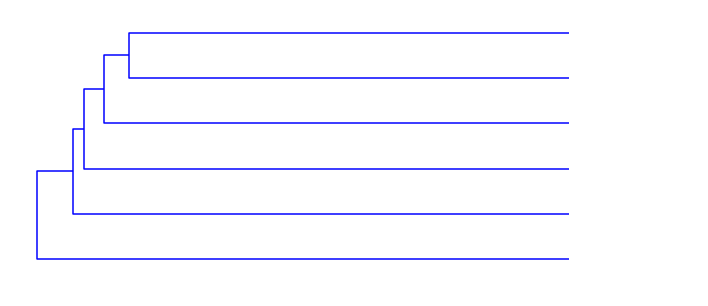

,age,fnlwgt,education-num,capital-gain,capital-loss,hours-per-week
age,1.000000,-0.076646,0.036527,0.077674,0.057775,0.068756
fnlwgt,-0.076646,1.000000,-0.043195,0.000432,-0.010252,-0.018768
education-num,0.036527,-0.043195,1.000000,0.122630,0.079923,0.148123
capital-gain,0.077674,0.000432,0.122630,1.000000,-0.031615,0.078409
capital-loss,0.057775,-0.010252,0.079923,-0.031615,1.000000,0.054256
hours-per-week,0.068756,-0.018768,0.148123,0.078409,0.054256,1.000000


In [41]:
xd.correlations()

/home/alejandro/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:245: RuntimeWarning: The input array could not be properly checked for nan values. nan values will be ignored.
  "values. nan values will be ignored.", RuntimeWarning)


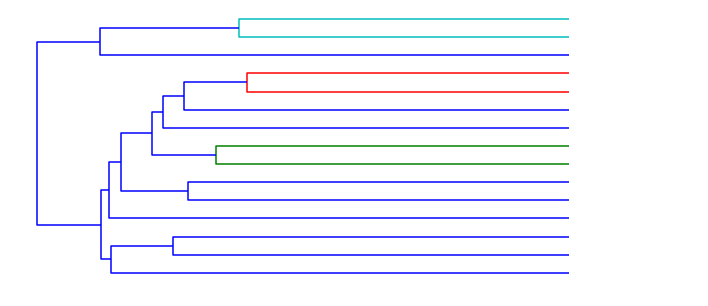

array([[ 1.        ,  0.05821793, -0.07814098, -0.02753357,  0.06634497,
        -0.37484987, -0.00480952, -0.32151467,  0.02818017,  0.10037342,
         0.12494799,  0.05848388,  0.14290681,  0.00750752,  0.27296206],
       [ 0.05821793,  1.        , -0.02887002,  0.00970422,  0.04002668,
        -0.07084739,  0.20712561, -0.11564865,  0.06361613,  0.11274998,
         0.03068833,  0.01345492,  0.13366052, -0.00690803,  0.06434877],
       [-0.07814098, -0.02887002,  1.        , -0.02139763, -0.03570649,
         0.03510239,  0.00165624,  0.01373364, -0.03604903,  0.02507814,
        -0.00603892, -0.00691384, -0.02162149, -0.07933568, -0.01073752],
       [-0.02753357,  0.00970422, -0.02139763,  1.        ,  0.20983273,
        -0.01332109, -0.03429336,  0.01642285,  0.01056352, -0.03450412,
         0.00535775,  0.00706282,  0.01060243,  0.08362025,  0.0296483 ],
       [ 0.06634497,  0.04002668, -0.03570649,  0.20983273,  1.        ,
        -0.06440846,  0.11508002, -0.0961136 , 

In [42]:
xd.correlations(include_categorical=True)

In [ ]:
corr = xd.correlations(include_categorical=True, plot_type="matrix")

In [ ]:
xd.convert_categories()

In [ ]:
xd.normalize_numeric()

array([0, 2, 3, 4])

# Experiments 
Below are todos and experiments

In [ ]:
import seaborn as sns
df

In [ ]:
a4_dims = (10,5)
fig, ax = plt.subplots(figsize=a4_dims)
sn.violinplot(x='hours-per-week', y='gender', data=df, ax=ax)

In [ ]:
# Categorical plots
# TODO: https://seaborn.pydata.org/tutorial/categorical.html#categorical-tutorial

# Numeric plots:
# TODO: https://seaborn.pydata.org/tutorial/axis_grids.html#grid-tutorial

# Statistical relationships with data
# TODO: https://seaborn.pydata.org/tutorial/relational.html#relational-tutorial
g = sns.PairGrid(df, hue="loan")
g.map(plt.scatter);

In [ ]:
def kdeplot(feature):
    plt.figure(figsize=(9, 4))
    plt.title("KDE for {}".format(feature))
    ax0 = sns.kdeplot(df[df['gender'] == ' Male'][feature].dropna(), color= 'navy', label= 'Loan: No')
    ax1 = sns.kdeplot(df[df['gender'] == ' Female'][feature].dropna(), color= 'orange', label= 'Loan: Yes')
kdeplot('hours-per-week')
# kdeplot('education-num')

In [ ]:
xd.df["gender"].unique()

# XMODEL

In [138]:
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, mean_squared_error, roc_curve, auc

from keras.layers import Input, Dense, Flatten, \
    Concatenate, concatenate, Dropout, Lambda
from keras.models import Model, Sequential
from keras.layers.embeddings import Embedding

def build_model(X):
    input_els = []
    encoded_els = []
    dtypes = list(zip(X.dtypes.index, map(str, X.dtypes)))
    for k,dtype in dtypes:
        input_els.append(Input(shape=(1,)))
        if dtype == "int8":
            e = Flatten()(Embedding(X[k].max()+1, 1)(input_els[-1]))
        else:
            e = input_els[-1]
        encoded_els.append(e)
    encoded_els = concatenate(encoded_els)

    layer1 = Dropout(0.5)(Dense(100, activation="relu")(encoded_els))
    out = Dense(1, activation='sigmoid')(layer1)

    # train model
    model = Model(inputs=input_els, outputs=[out])
    model.compile(optimizer="adam", loss='binary_crossentropy', metrics=['accuracy'])
    return model


def f_in(X, m=None):
    """Preprocess input so it can be provided to a function"""
    if m:
        return [X.iloc[:m,i] for i in range(X.shape[1])]
    else:
        return [X.iloc[:,i] for i in range(X.shape[1])]

def f_out(probs):
    """Convert probabilities into classes"""
    return list((probs >= 0.5).astype(int).T[0])


def confusion_matrix(y_target, y_predicted, scale=True, plot=True):
    confusion = sklearn.metrics.confusion_matrix(y_target, y_predicted)
    if scale:
        confusion = confusion.astype("float") / confusion.sum(axis=1)[:, np.newaxis]
    confusion_df = pd.DataFrame(confusion, index=["Denied", "Approved"], columns=["Denied", "Approved"])
    if plot:
        cm = sns.cubehelix_palette(8, start=2, rot=0, dark=0, light=1, reverse=True, as_cmap=True)
        sn.heatmap(confusion_df, annot=True, fmt='.2f', center=1, cmap=cm)
    return confusion_df


def plot_roc(y, probs, plot=True):
    
    fpr, tpr, _ = roc_curve(y, probs)

    roc_auc = auc(fpr, tpr)

    if plot:
        plt.figure()
        plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
        plt.plot([0, 1], [0, 1], 'k--')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.legend(loc="lower right")
        plt.rcParams.update(params)
        plt.show()
    
    return roc_auc

In [144]:
xd.reset()
_= xd.normalize_numeric()
_= xd.convert_categories()

df_train, df_test = split_test_set(
    xd.df,
    "loan",
    examples_per_class=20,
    key_features=["gender", "ethnicity", "age"],
    bins=9)

X_train = df_train.drop(xd._target_name, axis=1).copy()
y_train = df_train[xd._target_name].astype(int).values.copy()#
X_valid = df_test.drop(xd._target_name, axis=1).copy()
y_valid = df_test[xd._target_name].astype(int).values.copy()

# X = xd.df.drop(xd._target_name, axis=1).copy()
# y = xd.df[xd._target_name].astype(int).values.copy()

# X_train, X_valid, y_train, y_valid = \
#         train_test_split(X, y, test_size=0.2, random_state=7)

X_disp = xd.orig_df.drop(xd._target_name, axis=1).copy()
y_disp = xd.orig_df[xd._target_name].copy()
X_train_disp, X_valid_disp, y_train_disp, y_valid_disp = \
        train_test_split(X_disp, y_disp, test_size=0.2, random_state=7)

model = build_model(X)

model.fit(f_in(X_train), y_train, epochs=50,
    batch_size=512, shuffle=True, validation_data=(f_in(X_valid), y_valid),
    verbose=1, validation_split=0.05)

probabilities = model.predict(f_in(X_valid))
pred = f_out(probabilities)

Train on 31262 samples, validate on 1299 samples
Epoch 1/50
31262/31262 [==============================] - 1s 23us/step - loss: 0.5402 - acc: 0.7539 - val_loss: 0.3857 - val_acc: 0.8483
Epoch 2/50
31262/31262 [==============================] - 0s 4us/step - loss: 0.4111 - acc: 0.8140 - val_loss: 0.3271 - val_acc: 0.8607
Epoch 3/50
31262/31262 [==============================] - 0s 5us/step - loss: 0.3592 - acc: 0.8328 - val_loss: 0.2848 - val_acc: 0.8776
Epoch 4/50
31262/31262 [==============================] - 0s 5us/step - loss: 0.3364 - acc: 0.8423 - val_loss: 0.2693 - val_acc: 0.8884
Epoch 5/50
31262/31262 [==============================] - 0s 4us/step - loss: 0.3298 - acc: 0.8469 - val_loss: 0.2661 - val_acc: 0.8876
Epoch 6/50
31262/31262 [==============================] - 0s 4us/step - loss: 0.3263 - acc: 0.8488 - val_loss: 0.2631 - val_acc: 0.8868
Epoch 7/50
31262/31262 [==============================] - 0s 4us/step - loss: 0.3233 - acc: 0.8511 - val_loss: 0.2633 - val_acc: 0.883

In [145]:
score = model.evaluate(f_in(X_train), y_train, verbose=1)

print("Error %.4f: " % score[0])
print("Accuracy %.4f: " % (score[1]*100))

31262/31262 [==============================] - 0s 14us/step
Error 0.3043: 
Accuracy 85.9670: 


,Denied,Approved
Denied,0.948148,0.051852
Approved,0.397260,0.602740


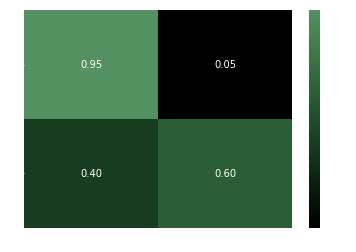

In [146]:
import seaborn as sn
confusion_matrix(y_valid, pred)

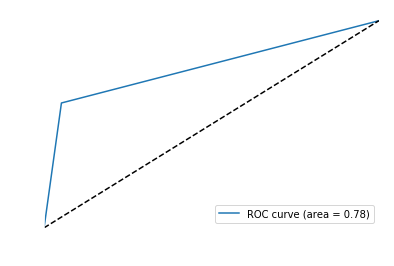

0.7754439370877727

In [147]:
plot_roc(y_valid, pred)

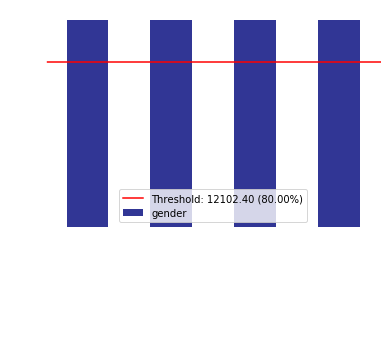

Train on 59188 samples, validate on 1299 samples
Epoch 1/50
59188/59188 [==============================] - 1s 14us/step - loss: 0.5836 - acc: 0.6790 - val_loss: 0.5850 - val_acc: 0.6767
Epoch 2/50
59188/59188 [==============================] - 0s 4us/step - loss: 0.4239 - acc: 0.8042 - val_loss: 0.4405 - val_acc: 0.7875
Epoch 3/50
59188/59188 [==============================] - 0s 4us/step - loss: 0.3822 - acc: 0.8223 - val_loss: 0.4321 - val_acc: 0.7937
Epoch 4/50
59188/59188 [==============================] - 0s 4us/step - loss: 0.3757 - acc: 0.8259 - val_loss: 0.4409 - val_acc: 0.7991
Epoch 5/50
59188/59188 [==============================] - 0s 4us/step - loss: 0.3733 - acc: 0.8278 - val_loss: 0.4231 - val_acc: 0.8037
Epoch 6/50
59188/59188 [==============================] - 0s 4us/step - loss: 0.3698 - acc: 0.8301 - val_loss: 0.4228 - val_acc: 0.8006
Epoch 7/50
59188/59188 [==============================] - 0s 4us/step - loss: 0.3687 - acc: 0.8300 - val_loss: 0.4135 - val_acc: 0.809

In [148]:
xd.reset()
xd.balance("gender", upsample=1)
xd.show_imbalance("gender")

_= xd.normalize_numeric()
_= xd.convert_categories()

df_train, df_test = split_test_set(
    xd.df,
    "loan",
    examples_per_class=20,
    key_features=["gender", "ethnicity", "age"],
    bins=9)

X_train = df_train.drop(xd._target_name, axis=1).copy()
y_train = df_train[xd._target_name].astype(int).values.copy()#
# X_valid = df_test.drop(xd._target_name, axis=1).copy()
# y_valid = df_test[xd._target_name].astype(int).values.copy()

# X = xd.df.drop(xd._target_name, axis=1).copy()
# y = xd.df[xd._target_name].astype(int).values.copy()

# X_train, X_valid, y_train, y_valid = \
#         train_test_split(X, y, test_size=0.2, random_state=7)


X_disp = xd.orig_df.drop(xd._target_name, axis=1).copy()
y_disp = xd.orig_df[xd._target_name].copy()
X_train_disp, X_valid_disp, y_train_disp, y_valid_disp = \
        train_test_split(X_disp, y_disp, test_size=0.2, random_state=7)


model = build_model(X)

model.fit(f_in(X_train), y_train, epochs=50,
    batch_size=512, shuffle=True, validation_data=(f_in(X_valid), y_valid),
    verbose=1, validation_split=0.05)

probabilities = model.predict(f_in(X_valid))
pred = f_out(probabilities)

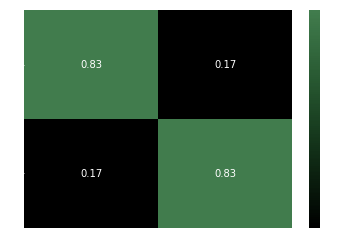

In [149]:
_= confusion_matrix(y_valid, pred)

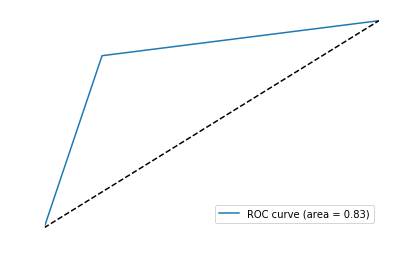

0.828951040081177

In [150]:
plot_roc(y_valid, pred)

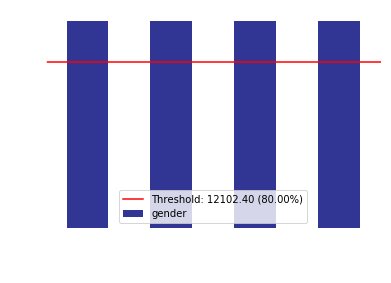

(loan  gender
 0     0         15128
       1         15128
 1     0         15128
       1         15128
 Name: gender, dtype: int64, loan  gender
 0     0         1.0
       1         1.0
 1     0         1.0
       1         1.0
 Name: gender, dtype: float64, loan  gender
 0     0         False
       1         False
 1     0         False
       1         False
 Name: gender, dtype: bool)

In [151]:
xd.show_imbalance("gender", bins=0)

/home/alejandro/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/alejandro/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1145: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
/home/alejandro/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/alejandro/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1145: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
/home/alejandro/anac

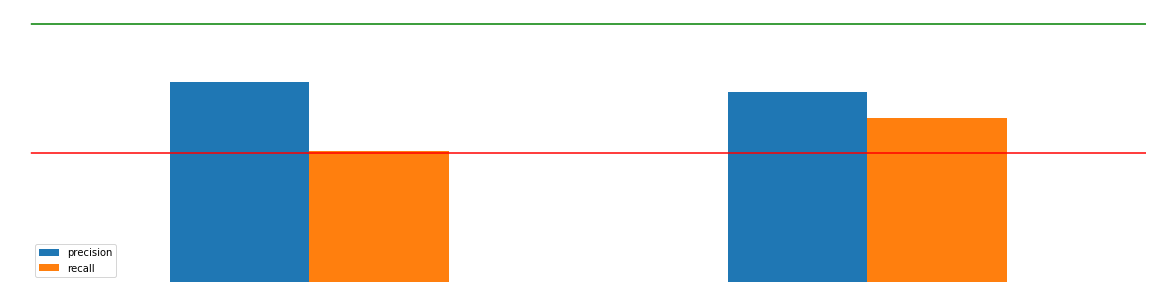

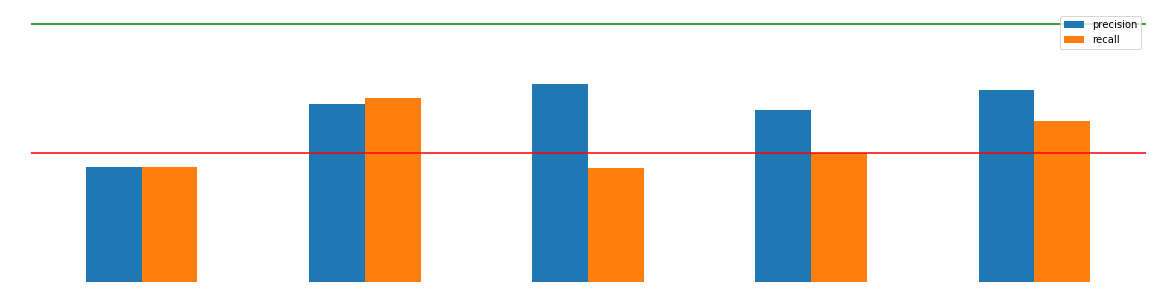

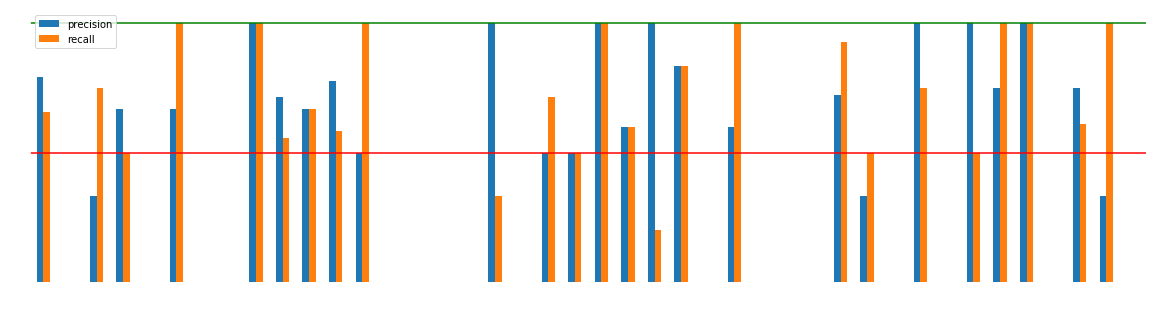

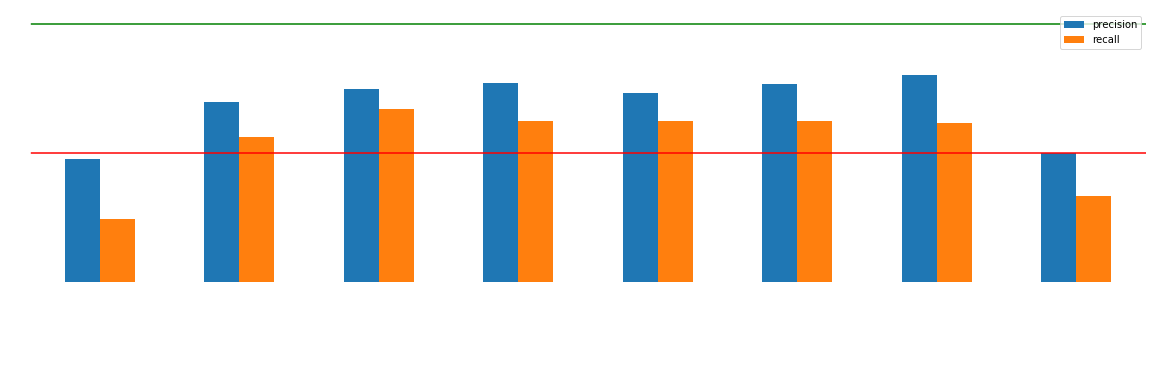

In [51]:
def group_by_columns(df, all_cols, bins=0):
    group_list = []
    for c in all_cols:
        col = df[c]
        if not bins:
            grp = c
        else:
            col_min = col.min()
            col_max = col.max()
            # TODO: Use the original bins for display purposes as they may come normalised
            col_bins = pd.cut(col, list(np.linspace(col_min, col_max, bins)))
            grp = col_bins

        group_list.append(grp)

    grouped = df.groupby(group_list)
    return grouped 

from sklearn.metrics import precision_recall_fscore_support

def individual_confusion(x_df, y_valid, y_pred, c, bins=0, average=None):
    x_tmp = x_df.copy()
    x_tmp["target"] = y_valid
    x_tmp["predicted"] = y_pred
    if not average:
        # TODO: Enable for multiclass multidisplay
        average = "binary" if len(np.unique(y_valid)) == 2 else "weighted"
    grouped = group_by_columns(x_tmp, [c], bins) 
    prfs = []
    classes = []
    for group, group_df in grouped:
        group_valid = group_df["target"]
        group_pred = group_df["predicted"]
        precision, recall, fscore, _ = \
            precision_recall_fscore_support(group_valid, group_pred, average=average)
        prfs.append([precision, recall])
        classes.append(str(group))
#         prfs.extend([precision,recall, fscore])
    
    prfs_df = pd.DataFrame(prfs, columns=["precision", "recall"], index=classes)
    prfs_df.plot.bar(figsize=(20,5))
    lp = plt.axhline(0.5, color='r')
#     lp = plt.axhline(prfs_df.mean(), color='y')
    lp = plt.axhline(1, color='g')
#     prfs_df["precision"].plot.bar()
#     lp = plt.axhline(0.5, color='r')
#     lp = plt.axhline(1, color='g')
#     plt.show()
#     prfs_df["recall"].plot.bar()
#     lp = plt.axhline(0.5, color='r')
#     lp = plt.axhline(1, color='g')

    
#     sns.barplot(list(range(0, len(prfs))),prfs)

for c in xd._protected_cols: 
    num_bins = 0 if c in xd._categorical_cols else 9
    individual_confusion(X_valid, y_valid, pred, c, bins=num_bins)

In [ ]:
from sklearn.metrics import classification_report

print(classification_report(y_valid, pred))

In [ ]:
sns.barplot([0,1], np.histogram(y_train,bins=2)[0])

In [ ]:
# Initialise XData object with dataframe and target col
import xai

target = "loan"
protected = ["gender", "ethnicity", "native-country", "age"]

df.head()

# View class imbalances
xai.show_imbalances(df, protected)

# View imbalance for specific column
xai.show_imbalance(df, "gender")

# View imbalance for specific column
xai.show_imbalance(df, "gender")

# Balance class that is under threshold
b_df = xai.balance(df, "gender")

# Visualise cross-class imbalance
xai.show_imbalance(b_df, "gender", cross=["loan"])

# Re-balance the original one
b_df = xai.balance(df, "gender", downsample=0.8, upsample=0.8)

# View correlations
xai.correlations(b_df)

# View all correlations
xai.correlations(include_categorical=True)

# Process and split test 
df = xai.normalize_numeric(df)
df = xai.convert_categories(df)
X_train, y_train, X_test, y_test = \
    xai.balanced_split(
        df,
        examples_per_class=20,
        key_features=["gender", "ethnicity", "age"],
        bins=6)

# Lets get some model predictions
model.fit(X_train)
preds = model.predict(X_test)

xai.roc_curve(X_test, y_test, preds)

xai.roc_curve(X_test, y_test, preds, "gender")

xai.precision(X_test, y_test, preds, "age")

xai.recall(X_test, y_test, preds, "age")

